In [2]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('Admission_Predict_Ver1.1.csv')

In [8]:
data.columns = ['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'adm_prob']

In [11]:
data = data[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'adm_prob']]

# 01_Visualizations

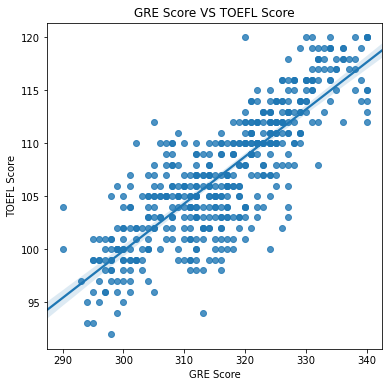

In [13]:
plt.figure(figsize=(6,6))
fig = sns.regplot(x="GRE Score",y="TOEFL Score",data=data)
plt.title("GRE Score VS TOEFL Score")
plt.show()

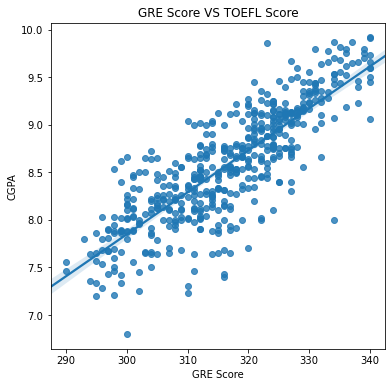

In [14]:
plt.figure(figsize=(6,6))
fig = sns.regplot(x="GRE Score",y="CGPA",data=data)
plt.title("GRE Score VS TOEFL Score")
plt.show()

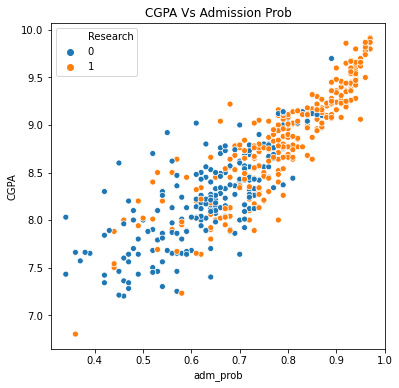

In [17]:
plt.figure(figsize=(6,6))
fig = sns.scatterplot(x="adm_prob",y="CGPA",data=data,hue='Research')
plt.title("CGPA Vs Admission Prob")
plt.show()

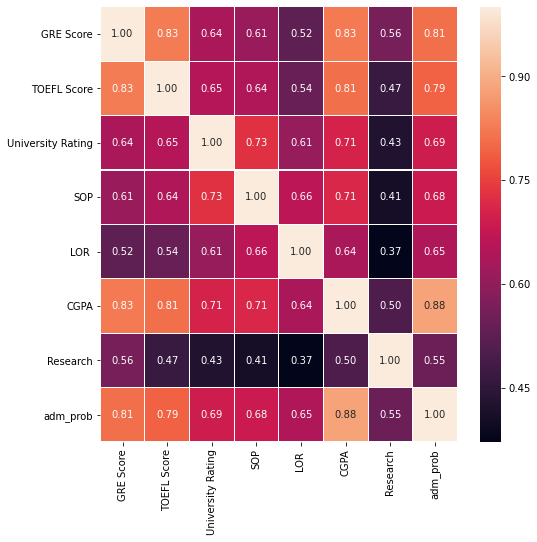

In [18]:
plt.figure(figsize=(8,8))
sns.heatmap(data.corr(),annot=True,linewidths=0.05,fmt='.2f')
plt.show()

# 02_Preprocessing

In [19]:
from sklearn import preprocessing

In [21]:
col_scale = ['GRE Score', 'TOEFL Score', 'SOP','LOR ', 'CGPA']
data[col_scale] = preprocessing.scale(data[col_scale]) 

In [40]:
features = data[col_scale]
target = data[['adm_prob']]

In [41]:
y = target.copy()
y['adm_prob'] = y['adm_prob'].map(lambda x:2 if(x>=0.8) else 1 if(x>=0.6) else 0)
target = y

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train,x_test,Y_train,y_test = train_test_split(features,target,test_size=0.2)

In [44]:
Xtrain = torch.from_numpy(X_train.values).float()
Xtest = torch.from_numpy(x_test.values).float()

In [50]:
Ytrain = torch.from_numpy(Y_train['adm_prob'].values).long()
Ytest = torch.from_numpy(y_test['adm_prob'].values).long()

# Modeling: Custom NN for Classification

In [54]:
import torch.nn as nn
import torch.nn.functional as F

In [55]:
input_size = Xtrain.shape[1]
output_size = len(target['adm_prob'].unique())

In [56]:
class Net(nn.Module):
    def __init__(self,hidden_size,activation_fn='relu',apply_dropout=False):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(input_size, output_size)
        
        self.hidden_size = hidden_size
        self.activation_fn = activation_fn
        
        self.dropout = None
        if(apply_dropout):
            self.dropout = nn.Dropout(0.2)
    
    def forward(self,x):
        activation_fn = None
        if(self.activation_fn == 'sigmoid'):
            activation_fn = F.torch.sigmoid
        elif(self.activation_fn == 'tanh'):
            activation_fn = F.torch.tanh
        elif(activation_fn == 'relu'):
            activation_fn = F.relu
        
        x = activation_fn(self.fc1(x))
        x = activation_fn(self.fc2(x))
        
        if(self.dropout!=None):
            x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim = -1)

In [57]:
import torch.optim as optim

In [79]:
def train_and_evaluate_model(model, learn_rate=0.001):
    epoch_data = []
    epochs = 1000
    optimizer = optim.Adam(model.parameters(),lr=learn_rate)
    loss_fn = nn.NLLLoss()
    test_accuracy = 0.0
    for epoch in range(1,epochs):
        optimizer.zero_grad()
        model.train()
        Ypred=model(Xtrain)
        loss = loss_fn(Ypred,Ytrain)
        loss.backward()
        
        optimizer.step()
        model.eval()
        
        Ypred_test = model(Xtest)
        loss_test = loss_fn(Ypred_test,Ytest)
        
        _,pred = Ypred_test.data.max(1)
        test_accuracy = pred.eq(Ytest.data).sum().item() / y_test.values.size
        epoch_data.append([epoch,loss.data.item(), loss_test.data.item(),test_accuracy])
        
        if(epoch%100==0):
            print('Epoch - %d (%d%%) train loss - %.2f test loss - %.2f Test accuracy - %.4f'\
                 %(epoch,epoch/150 * 10, loss.data.item(),loss_test.data.item(), test_accuracy))
    return {'model': model,
           'epoch_data': epoch_data,
           'num_epochs':epochs,
           'optimizer':optimizer,
           'loss_fn':loss_fn,
           'test_accuracy':test_accuracy,
            '_, pred':Ypred_test.data.max(1),
           'actual_test_label':Ytest,}
            
        

# Calling_With_Diff_Para:

In [81]:
# 01-sigmoid | no-dropout
net = Net(hidden_size=3,activation_fn='sigmoid',apply_dropout=False)
print(net)
result_3_sigmoid = train_and_evaluate_model(net)

Net(
  (fc1): Linear(in_features=5, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=3, bias=True)
  (fc3): Linear(in_features=5, out_features=3, bias=True)
)
Epoch - 100 (6%) train loss - 1.06 test loss - 1.06 Test accuracy - 0.5000
Epoch - 200 (13%) train loss - 1.03 test loss - 1.04 Test accuracy - 0.5000
Epoch - 300 (20%) train loss - 1.02 test loss - 1.04 Test accuracy - 0.5000
Epoch - 400 (26%) train loss - 1.01 test loss - 1.03 Test accuracy - 0.5000
Epoch - 500 (33%) train loss - 1.00 test loss - 1.03 Test accuracy - 0.5000
Epoch - 600 (40%) train loss - 0.99 test loss - 1.01 Test accuracy - 0.5000
Epoch - 700 (46%) train loss - 0.97 test loss - 0.99 Test accuracy - 0.5000
Epoch - 800 (53%) train loss - 0.94 test loss - 0.96 Test accuracy - 0.5000
Epoch - 900 (60%) train loss - 0.90 test loss - 0.92 Test accuracy - 0.7200


In [82]:
# 02-sigmoid | With dropout
net = Net(hidden_size=3,activation_fn='sigmoid',apply_dropout=True)
print(net)
result_3_sigmoid = train_and_evaluate_model(net)

Net(
  (fc1): Linear(in_features=5, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=3, bias=True)
  (fc3): Linear(in_features=5, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Epoch - 100 (6%) train loss - 1.12 test loss - 1.09 Test accuracy - 0.5000
Epoch - 200 (13%) train loss - 1.06 test loss - 1.05 Test accuracy - 0.5000
Epoch - 300 (20%) train loss - 1.03 test loss - 1.03 Test accuracy - 0.5000
Epoch - 400 (26%) train loss - 1.01 test loss - 1.02 Test accuracy - 0.5000
Epoch - 500 (33%) train loss - 1.00 test loss - 1.01 Test accuracy - 0.5000
Epoch - 600 (40%) train loss - 1.00 test loss - 0.99 Test accuracy - 0.5000
Epoch - 700 (46%) train loss - 0.98 test loss - 0.97 Test accuracy - 0.5000
Epoch - 800 (53%) train loss - 0.95 test loss - 0.94 Test accuracy - 0.7100
Epoch - 900 (60%) train loss - 0.92 test loss - 0.90 Test accuracy - 0.7300


In [87]:
# 03-tanh | no-dropout | 50 layers
net = Net(hidden_size=50,activation_fn='tanh')
print(net)
result_50_sigmoid = train_and_evaluate_model(net)

Net(
  (fc1): Linear(in_features=5, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=5, out_features=3, bias=True)
)
Epoch - 100 (6%) train loss - 0.61 test loss - 0.58 Test accuracy - 0.7900
Epoch - 200 (13%) train loss - 0.46 test loss - 0.45 Test accuracy - 0.8300
Epoch - 300 (20%) train loss - 0.43 test loss - 0.42 Test accuracy - 0.8300
Epoch - 400 (26%) train loss - 0.42 test loss - 0.41 Test accuracy - 0.8500
Epoch - 500 (33%) train loss - 0.41 test loss - 0.41 Test accuracy - 0.8500
Epoch - 600 (40%) train loss - 0.40 test loss - 0.40 Test accuracy - 0.8500
Epoch - 700 (46%) train loss - 0.39 test loss - 0.40 Test accuracy - 0.8500
Epoch - 800 (53%) train loss - 0.38 test loss - 0.40 Test accuracy - 0.8500
Epoch - 900 (60%) train loss - 0.37 test loss - 0.40 Test accuracy - 0.8500


In [85]:
# 04-tanh | no-dropout | 1000 layers : Not much improvement.
net = Net(hidden_size=1000,activation_fn='tanh')
print(net)
result_3_sigmoid = train_and_evaluate_model(net)

Net(
  (fc1): Linear(in_features=5, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=5, out_features=3, bias=True)
)
Epoch - 100 (6%) train loss - 0.36 test loss - 0.39 Test accuracy - 0.8600
Epoch - 200 (13%) train loss - 0.22 test loss - 0.43 Test accuracy - 0.8300
Epoch - 300 (20%) train loss - 0.10 test loss - 0.53 Test accuracy - 0.8100
Epoch - 400 (26%) train loss - 0.05 test loss - 0.62 Test accuracy - 0.8100
Epoch - 500 (33%) train loss - 0.03 test loss - 0.70 Test accuracy - 0.8100
Epoch - 600 (40%) train loss - 0.02 test loss - 0.77 Test accuracy - 0.8200
Epoch - 700 (46%) train loss - 0.01 test loss - 0.82 Test accuracy - 0.8200
Epoch - 800 (53%) train loss - 0.01 test loss - 0.87 Test accuracy - 0.8300
Epoch - 900 (60%) train loss - 0.01 test loss - 0.91 Test accuracy - 0.8300


In [86]:
# 05-tanh | with-dropout | 1000 layers
net = Net(hidden_size=1000,activation_fn='tanh',apply_dropout=True)
print(net)
result_3_sigmoid = train_and_evaluate_model(net)

Net(
  (fc1): Linear(in_features=5, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=5, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Epoch - 100 (6%) train loss - 0.36 test loss - 0.39 Test accuracy - 0.8500
Epoch - 200 (13%) train loss - 0.27 test loss - 0.42 Test accuracy - 0.8400
Epoch - 300 (20%) train loss - 0.16 test loss - 0.48 Test accuracy - 0.8000
Epoch - 400 (26%) train loss - 0.11 test loss - 0.58 Test accuracy - 0.8100
Epoch - 500 (33%) train loss - 0.06 test loss - 0.66 Test accuracy - 0.8200
Epoch - 600 (40%) train loss - 0.05 test loss - 0.75 Test accuracy - 0.8200
Epoch - 700 (46%) train loss - 0.03 test loss - 0.79 Test accuracy - 0.8200
Epoch - 800 (53%) train loss - 0.02 test loss - 0.85 Test accuracy - 0.8200
Epoch - 900 (60%) train loss - 0.02 test loss - 0.86 Test accuracy - 0.8200


In [89]:
# so final is : tanh | 50 Layers
result_model = result_50_sigmoid
df_epochs_data = pd.DataFrame(result_model['epoch_data'],
                             columns=["epoch","train_loss","test_loss","accuracy"])

In [90]:
import matplotlib.pyplot as plt

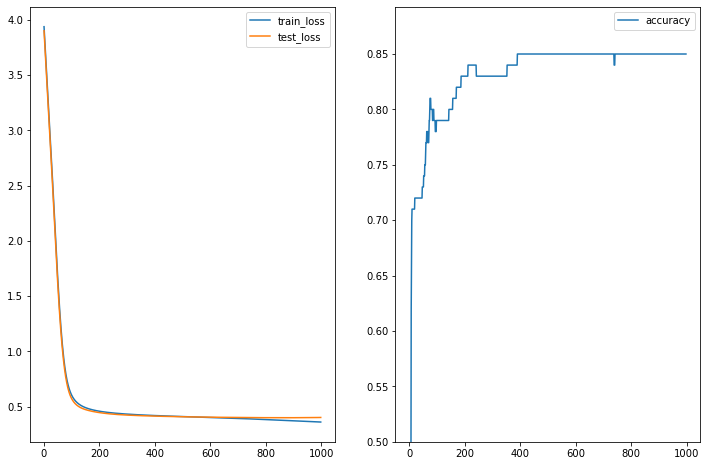

In [91]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
df_epochs_data[["train_loss","test_loss"]].plot(ax=ax1)
df_epochs_data[["accuracy"]].plot(ax=ax2)

plt.ylim(bottom=0.5)
plt.show()